## 1. Checking the environment


In [ ]:
import sys
print(sys.executable)

In [ ]:
# Version of python
!python --version

In [ ]:
# If mlflow is installed
!mlflow --version

In [ ]:
# If Tensorflow is installed
import tensorflow as tf
print(f'Tensorflow version = {tf.__version__}\n')



## 2. MLflow Components

The MLflow Model Registry component is a centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of MLflow Models. It provides model lineage (which MLflow Experiment and Run produced the model), model versioning, stage transitions, annotations, and deployment management.

In this notebook, you use each of the MLflow Model Registry's components to develop and manage a production machine learning application. This notebook covers the following topics:
* Log model experiments with MLflow
* Register models with the Model Registry
* Add model description and version the model stage transitions
* Search and discover models in the MR
* Archive and delete models

## 2.1 ML Application Example using MLFlow
## Load the dataset

The following cells load a dataset containing weather data and power output information for a wind farm in the United States. The dataset contains wind direction, wind speed, and air temperature features sampled every eight hours (once at 00:00, once at 08:00, and once at 16:00), as well as daily aggregate power output (power), over several years.


In [ ]:
import pandas as pd

wind_farm_data = pd.read_csv("https://github.com/dbczumar/model-registry-demo-notebook/raw/master/dataset/windfarm_data.csv", index_col=0)


def get_training_data():
  training_data = pd.DataFrame(wind_farm_data["2014-01-01":"2018-01-01"])
  X = training_data.drop(columns="power")
  y = training_data["power"]
  return X, y


def get_validation_data():

  validation_data = pd.DataFrame(wind_farm_data["2018-01-01":"2019-01-01"])
  X = validation_data.drop(columns="power")
  y = validation_data["power"]
  return X, y


def get_weather_and_forecast():

  format_date = lambda pd_date : pd_date.date().strftime("%Y-%m-%d")
  today = pd.Timestamp('today').normalize()
  week_ago = today - pd.Timedelta(days=5)
  week_later = today + pd.Timedelta(days=5)

  past_power_output = pd.DataFrame(wind_farm_data)[format_date(week_ago):format_date(today)]

  weather_and_forecast = pd.DataFrame(wind_farm_data)[format_date(week_ago):format_date(week_later)]

  if len(weather_and_forecast) < 10:
    past_power_output = pd.DataFrame(wind_farm_data).iloc[-10:-5]
    weather_and_forecast = pd.DataFrame(wind_farm_data).iloc[-10:] 

  return weather_and_forecast.drop(columns="power"), past_power_output["power"]

#### 1. Display a sample of the data for reference.

In [ ]:
wind_farm_data["2019-01-01":"2019-02-01"]

## Train a power forecasting model and track it with MLflow

The following cells train a neural network to predict power output based on the weather features in the dataset. MLflow is used to track the model's hyperparameters, performance metrics, source code, and artifacts.


#### 2. Define a power forecasting model using TensorFlow Keras.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# Check for available physical devices
gpus = tf.config.list_physical_devices("GPU")
cpus = tf.config.list_physical_devices("CPU")

if len(gpus) > 0:
    print(gpus)
else:
    print("NO GPUS FOUND! Using only CPUs!")

print(f'\n{cpus}\n')

In [ ]:
def train_keras_model(X, y):
  
  model = Sequential()
  model.add(Dense(100, input_shape=(X_train.shape[-1],), activation="relu", name="hidden_layer"))
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")

  model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=.2)

  return model

#### MLflow part

**! Configure IMPORTANT CONSTANTS !:**

In [ ]:
#set the environmental vars to allow 'mlflow_user' to track experiments using MLFlow
import os
import getpass

# IMPORTANT CONSTANTS TO DEFINE
# MLFLOW CREDENTIALS (Nginx). PUT REAL ONES!
# for direct API calls via HTTP we need to inject credentials
MLFLOW_TRACKING_USERNAME = 'mlflow_user'
MLFLOW_TRACKING_PASSWORD =  getpass.getpass()  # inject password by typing manually
# for MLFLow-way we have to set the following environment variables
os.environ['MLFLOW_TRACKING_USERNAME'] = MLFLOW_TRACKING_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = MLFLOW_TRACKING_PASSWORD

# Remote MLFlow server
MLFLOW_REMOTE_SERVER="http://mlflow.dev.ai4eosc.eu" #193.196.36.191
# Name of the experiment (e.g. name of the  code repository)
MLFLOW_EXPERIMENT_NAME="wind_power_forecast"
# Name of the model to train. HAS TO BE UNIQUE, Please, DEFINE ONE!
MLFLOW_MODEL_NAME="testuser-something-to-delete"

Train the model and use MLflow to log and track its parameters, metrics, artifacts, and source code.

In [ ]:
import mlflow
import mlflow.keras
import mlflow.tensorflow

#from mlflow.tracking import MlflowClient
 
X_train, y_train = get_training_data()

#Set the MLflow server and backend and artifact stores
mlflow.set_tracking_uri(MLFLOW_REMOTE_SERVER)

#set an experiment name for all different runs
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

#set your user-name to distinguish who logged a specific run
mlflow.set_tag('User', 'your-user-name')#client = MlflowClient()
#run = client.create_run(experiment.experiment_id)
#run = mlflow.start_run(run_id = run.info.run_id)

with mlflow.start_run():
#with run:

  # Automatically capture the model's parameters, metrics, artifacts,and source code with the `autolog()` function

  mlflow.tensorflow.autolog()  

  train_keras_model(X_train, y_train)

  run_id = mlflow.active_run().info.run_id

#mlflow.end_run()

In [ ]:
# Print the run_id
print(F"\nRUN_ID: {run_id} \n")

### Register the model with the MLflow Model Registry API

Now that a forecasting model has been trained and tracked with MLflow, the next step is to register it with the MLflow Model Registry. You can register and manage models using the MLflow UI or the MLflow API .

The following cells use the API to register your forecasting model, add rich model descriptions, and perform stage transitions. See the documentation for the UI workflow.

Create a new registered model using the API

The following cells use the `mlflow.register_model()` function to create a new registered model whose name begins with the string defined in `MLFLOW_MODEL_NAME`. This also creates a new model version (for example, Version 1 of power-forecasting-model).


In [ ]:
# The default path where the MLflow autologging function stores the model
model_uri = F"runs:/{run_id}/model"
model_details = mlflow.register_model(model_uri=model_uri, name=MLFLOW_MODEL_NAME)

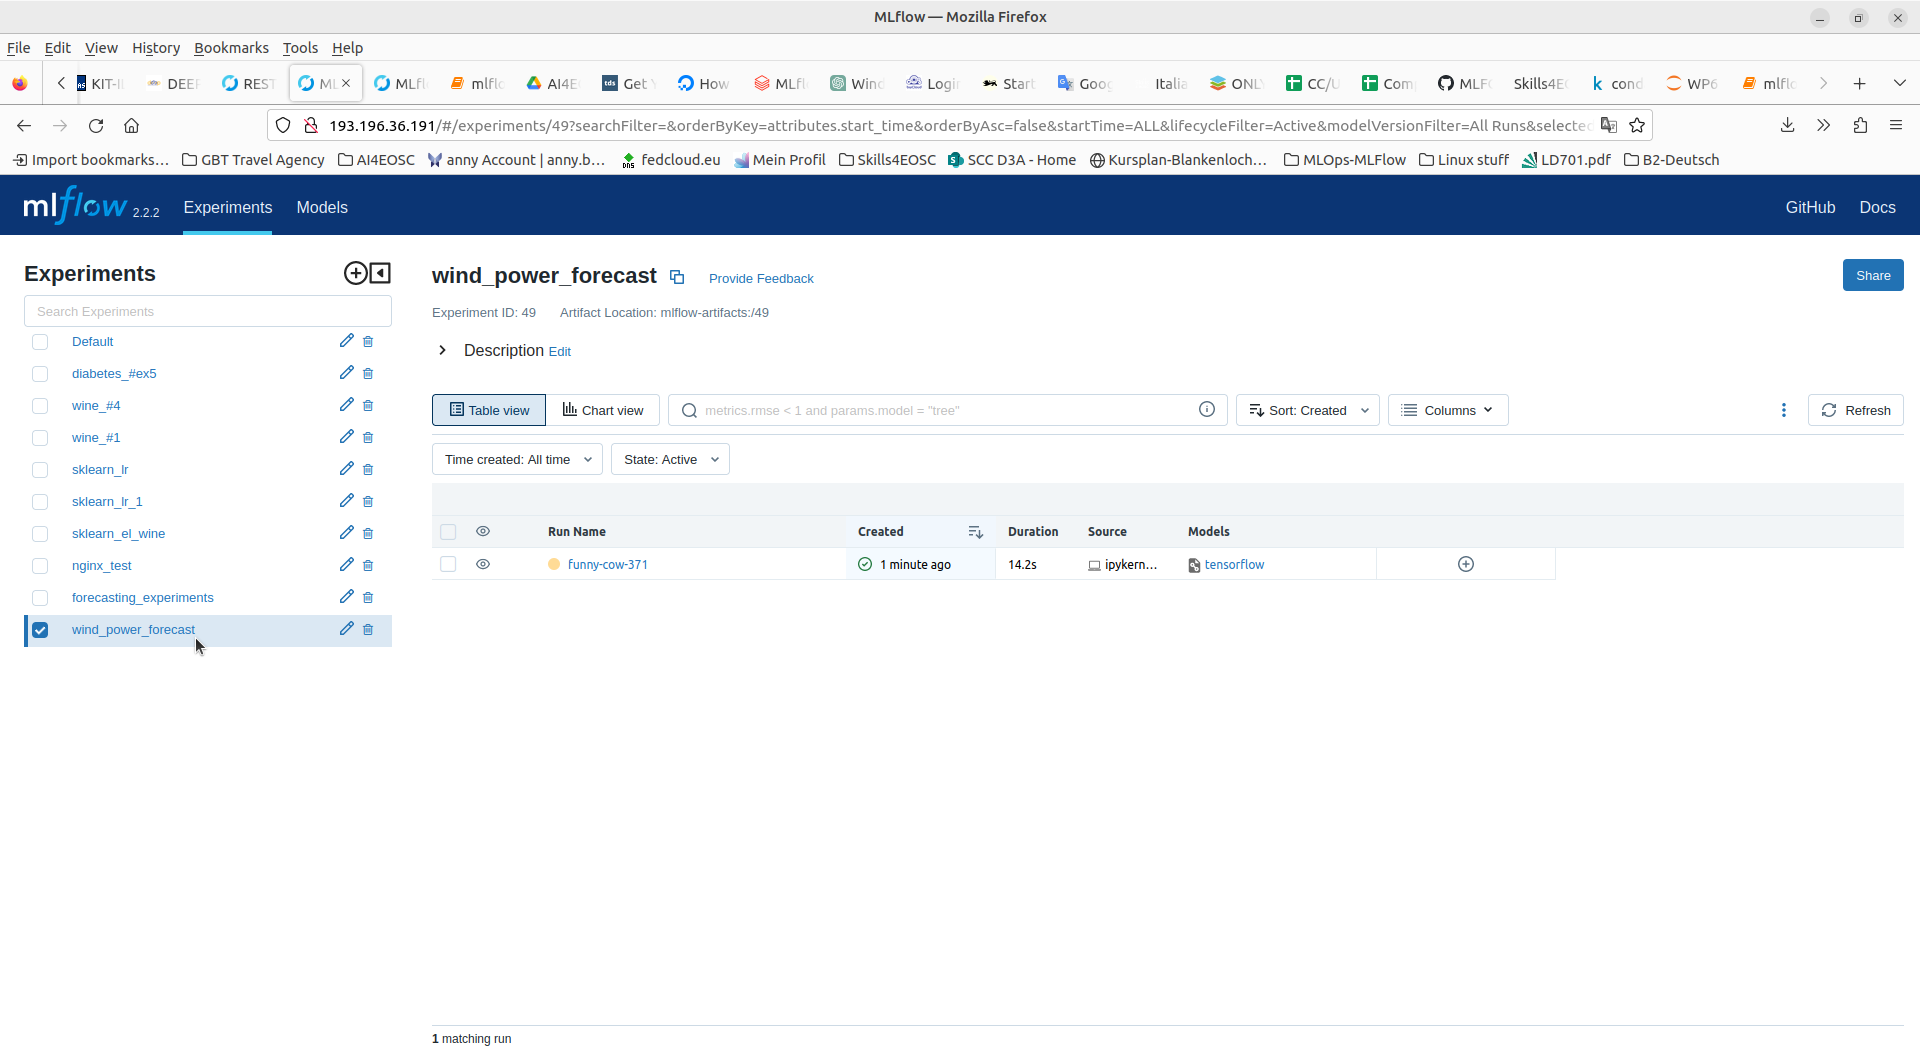

In [ ]:
import time
from mlflow.tracking.client import MlflowClient
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus


def wait_until_ready(model_name, model_version):

  client = MlflowClient()

  for _ in range(10):

    model_version_details = client.get_model_version(
      name=MLFLOW_MODEL_NAME,
      version=model_version,
    )

    status = ModelVersionStatus.from_string(model_version_details.status)

    print("Model status: %s" % ModelVersionStatus.to_string(status))

    if status == ModelVersionStatus.READY:

      break

    time.sleep(1)


wait_until_ready(model_details.name, model_details.version)

### Add model descriptions

Add a high-level description to the registered model, including the machine learning problem and dataset.

In [ ]:
from mlflow.tracking.client import MlflowClient

client = MlflowClient()
client.update_registered_model(
  name=model_details.name,
  description="This model forecasts the power output of a wind farm based on weather data. The weather data consists of three features: wind speed, wind direction, and air temperature. // user"
)

Perform a model staging using RestAPI
First need to check if api is working:
http://   /api/2.0/mlflow

restapi tutorial to transition stage: https://mlflow.org/docs/latest/rest-api.html#transition-modelversion-stage



In [ ]:
# Let's use requests library to perform API call
import requests
from requests.auth import HTTPBasicAuth

# Get info about the run
auth=HTTPBasicAuth(MLFLOW_TRACKING_USERNAME, MLFLOW_TRACKING_PASSWORD)
headers = {'content-type': 'application/json'}
params = { 'run_id' : run_id }
url = MLFLOW_REMOTE_SERVER + "/api/2.0/mlflow/runs/get"
response = requests.get(url, auth=auth, headers=headers, params=params)
response.json()

In [ ]:
# Transition model to Production using API call
auth=HTTPBasicAuth(MLFLOW_TRACKING_USERNAME, MLFLOW_TRACKING_PASSWORD)
headers = {'content-type': 'application/json'}
data = {"comment": "Please move this model into production!", 
        "name": MLFLOW_MODEL_NAME, 
        "version": "1", 
        "stage": "Production"}
url = MLFLOW_REMOTE_SERVER + "/api/2.0/mlflow/model-versions/transition-stage"

response = requests.post(url, auth=auth, headers=headers, json=data)
response.json()

In [ ]:
# or using the script:

client.transition_model_version_stage(
  name=model_details.name,
  version=model_details.version,
  stage='Production'

)

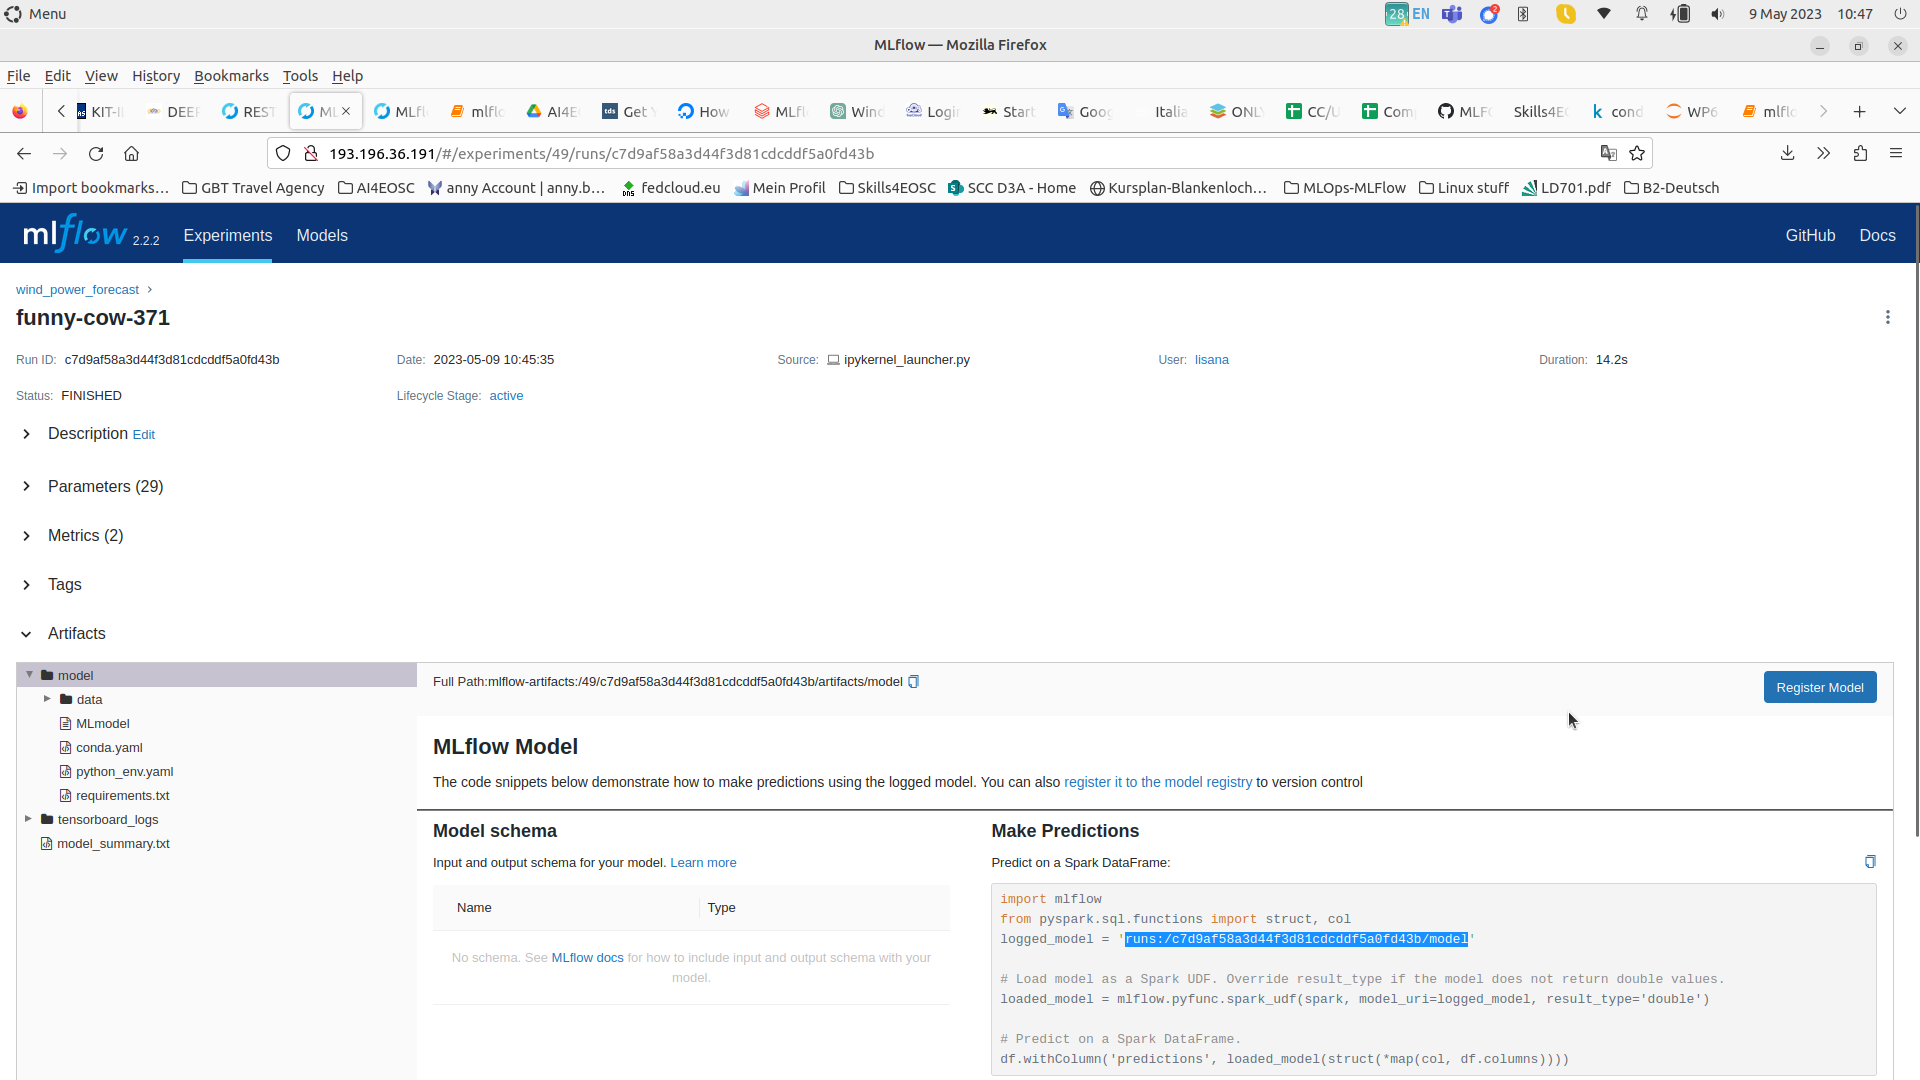

Use the `MlflowClient.get_model_version()` function to fetch the model's current stage.

In [ ]:
model_version_details = client.get_model_version(
  name=model_details.name,
  version=model_details.version,
)

print(F"The current model stage is: '{model_version_details.current_stage}'")

The MLflow Model Registry allows multiple model versions to share the same stage. When referencing a model by stage, the Model Registry will use the latest model version (the model version with the largest version ID). The MlflowClient.get_latest_versions() function fetches the latest model version for a given stage or set of stages. The following cell uses this function to print the latest version of the power forecasting model that is in the Production stage.

In [ ]:
latest_version_info = client.get_latest_versions(MLFLOW_MODEL_NAME, stages=["Production"])

latest_production_version = latest_version_info[0].version

print(F"The latest production version of the model \"{MLFLOW_MODEL_NAME}\" is {latest_production_version}")

## Integrate the model with the forecasting application

Now that you have trained and registered a power forecasting model with the MLflow Model Registry, the next step is to integrate it with an application. This application fetches a weather forecast for the wind farm over the next five days and uses the model to produce power forecasts. For example purposes, the application consists of a simple forecast_power() function (defined below) that is executed within this notebook. In practice, you may want to execute this function as a recurring batch inference job using the Databricks Jobs service.

The following section demonstrates how to load model versions from the MLflow Model Registry for use in applications. The Forecast power output with the production model section uses the Production model to forecast power output for the next five days.


### Load versions of the registered model

The MLflow Models component defines functions for loading models from several machine learning frameworks. For example, mlflow.tensorflow.load_model() is used to load Tensorflow Keras models that were saved in MLflow format, and mlflow.sklearn.load_model() is used to load scikit-learn models that were saved in MLflow format.

These functions can load models from the MLflow Model Registry.


In [ ]:
import mlflow.pyfunc

model_version_uri = F"models:/{MLFLOW_MODEL_NAME}/1"

print(F"Loading registered model version from URI: {model_version_uri}")

model_version_1 = mlflow.pyfunc.load_model(model_version_uri)


Load a model from production stage:

In [ ]:
model_production_uri = F"models:/{MLFLOW_MODEL_NAME}/production"

print(F"Loading registered model version from URI: '{model_production_uri}'")

model_production = mlflow.pyfunc.load_model(model_production_uri)

### Forecast power output with the production model

In this section, the production model is used to evaluate weather forecast data for the wind farm. The forecast_power() application loads the latest version of the forecasting model from the specified stage and uses it to forecast power production over the next five days.


In [ ]:
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

def plot(model_name, model_stage, model_version, power_predictions, past_power_output):

  index = power_predictions.index

  fig = plt.figure(figsize=(11, 7))

  ax = fig.add_subplot(111)

  ax.set_xlabel("Date", size=20, labelpad=20)

  ax.set_ylabel("Power\noutput\n(MW)", size=20, labelpad=60, rotation=0)

  ax.tick_params(axis='both', which='major', labelsize=17)

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

  ax.plot(index[:len(past_power_output)], past_power_output, label="True", color="red", alpha=0.5, linewidth=4)

  ax.plot(index, power_predictions.squeeze(), "--", label="Predicted by '%s'\nin stage '%s' (Version %d)" % (model_name, model_stage, model_version), color="blue", linewidth=3)

  ax.set_ylim(ymin=0, ymax=max(3500, int(max(power_predictions.values) * 1.3)))

  ax.legend(fontsize=14)

  plt.title("Wind farm power output and projections", size=24, pad=20)

  plt.tight_layout()

  display(plt.show())
  

from mlflow.tracking.client import MlflowClient

def forecast_power(model_name, model_stage):

  client = MlflowClient()

  model_version = client.get_latest_versions(model_name, stages=[model_stage])[0].version

  model_uri = F"models:/{model_name}/{model_stage}"

  model = mlflow.pyfunc.load_model(model_uri)

  weather_data, past_power_output = get_weather_and_forecast()

  power_predictions = pd.DataFrame(model.predict(weather_data))

  power_predictions.index = pd.to_datetime(weather_data.index)

  print(power_predictions)

  plot(model_name, model_stage, int(model_version), power_predictions, past_power_output)


In [ ]:
forecast_power(MLFLOW_MODEL_NAME, "Production")

## Create and deploy a new model version

The MLflow Model Registry enables you to create multiple model versions corresponding to a single registered model. By performing stage transitions, you can seamlessly integrate new model versions into your staging or production environments. Model versions can be trained in different machine learning frameworks (such as scikit-learn and tensorflow); MLflow's python_function provides a consistent inference API across machine learning frameworks, ensuring that the same application code continues to work when a new model version is introduced.

The following sections create a new version of the power forecasting model using scikit-learn, perform model testing in Staging, and update the production application by transitioning the new model version to Production.


In [ ]:
#classic ML application ; The following cell trains a random forest model using scikit-learn and 
#registers it with the MLflow Model Registry via the mlflow.sklearn.log_model() function.
##(debug) MLFLOW_REMOTE_SERVER="http://193.196.36.191:5000"
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

 #Set the MLflow server and backend and artifact stores
mlflow.set_tracking_uri(MLFLOW_REMOTE_SERVER)

#set an experiment name for all different runs
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)


# enable autologging
mlflow.sklearn.autolog()

with mlflow.start_run():

  n_estimators = 100
  mlflow.log_param("n_estimators", n_estimators)

  run_id = mlflow.active_run().info.run_id
  rand_forest = RandomForestRegressor(n_estimators=n_estimators)
  rand_forest.fit(X_train, y_train)

  val_x, val_y = get_validation_data()
  mse = mean_squared_error(rand_forest.predict(val_x), val_y)
  print("Validation MSE: %d" % mse)
  mlflow.log_metric("mse", mse)
    
  #mlflow.sklearn.log_model(rand_forest, "sk_models")


  # Specify the `registered_model_name` parameter of the `mlflow.sklearn.log_model()`
  # function to register the model with the MLflow Model Registry. This automatically
  # creates a new model version


  #mlflow.sklearn.log_model(sk_model, rand_forest)
    

  #mlflow.end_run()  
    
      #mlflow.tensorflow.autolog()  
#
 # train_keras_model(X_train, y_train)

 # run_id = mlflow.active_run().info.run_id

#mlflow.end_run()




In [ ]:
# The default path where the MLflow autologging function stores the model
model_uri = F"runs:/{run_id}/model"
client = MlflowClient()
# Add newly trained model as new version for our MLFLOW_MODEL_NAME
client.create_model_version(source=model_uri, run_id=run_id, name=MLFLOW_MODEL_NAME)

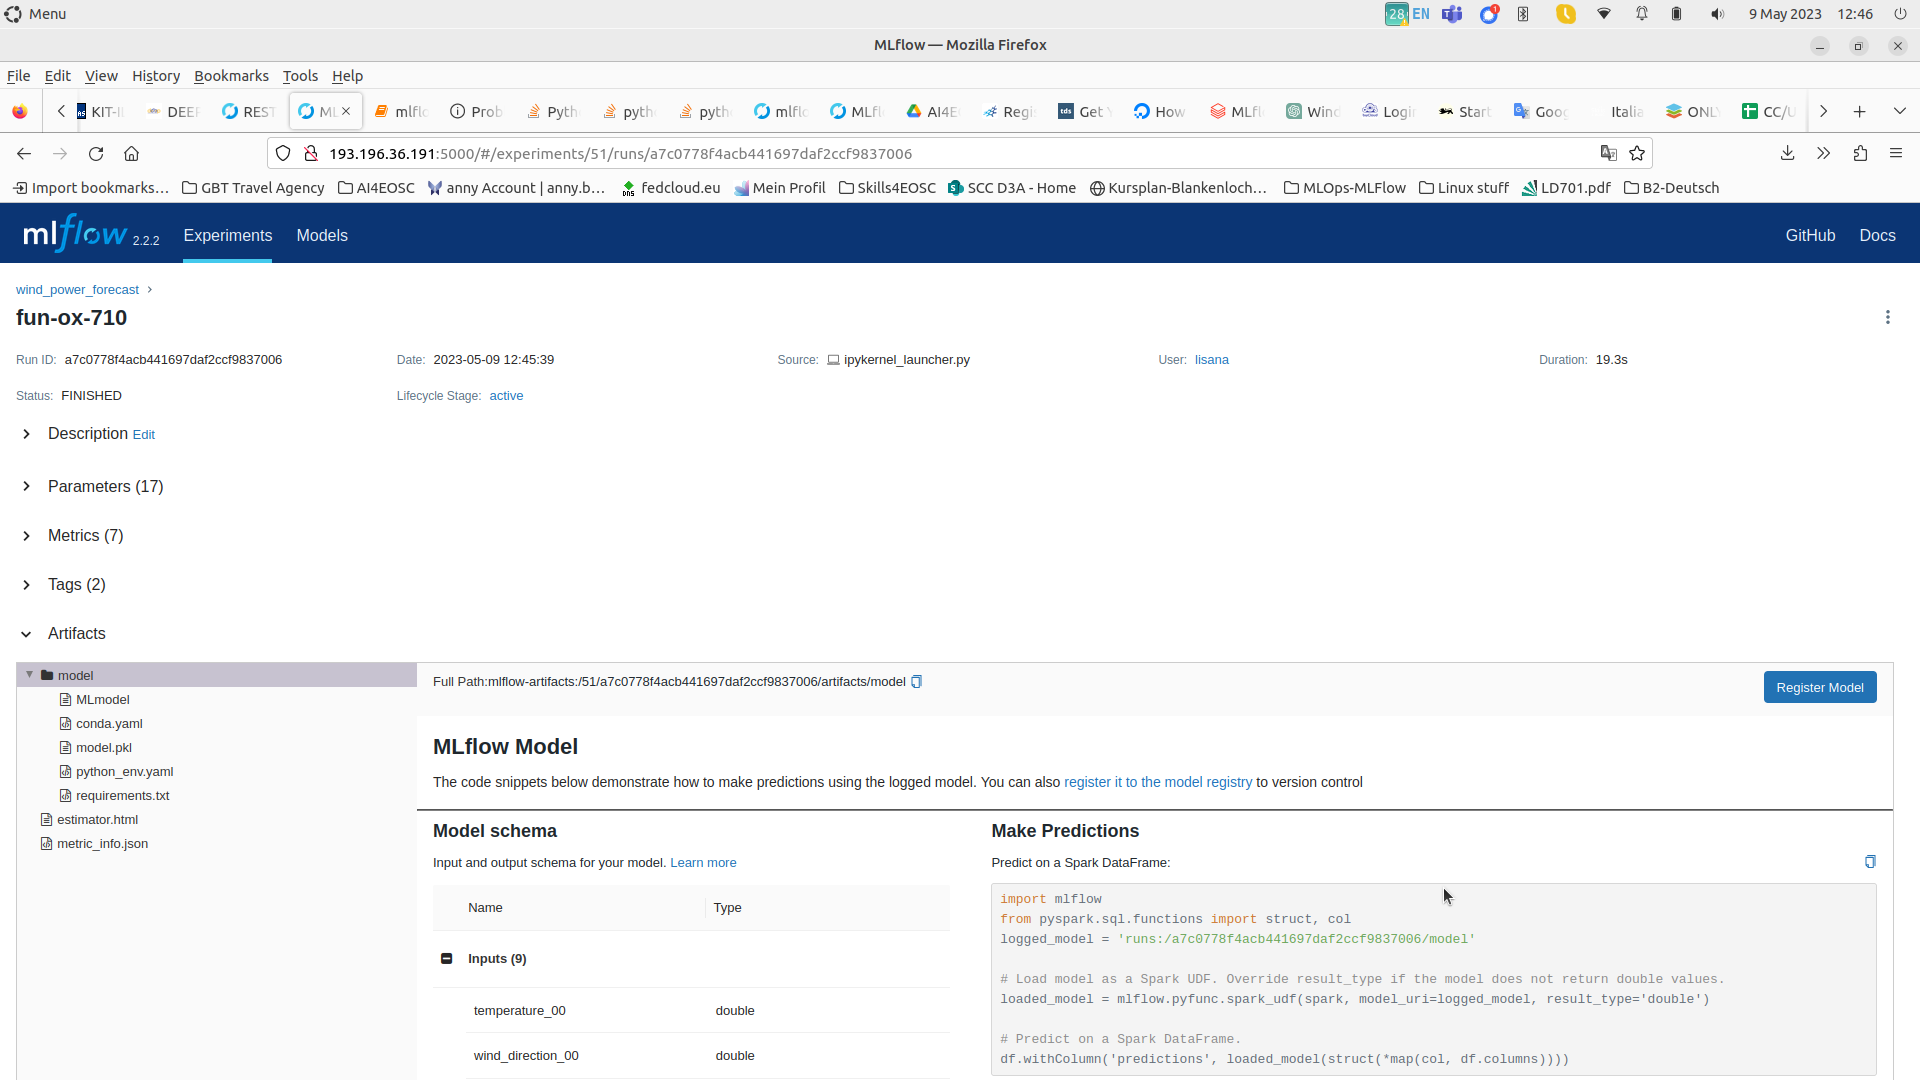

#### Fetch the new model using model search registry


In [ ]:
from mlflow.tracking.client import MlflowClient

client = MlflowClient()

model_version_infos = client.search_model_versions(F"name = '{MLFLOW_MODEL_NAME}'")

new_model_version = max([model_version_info.version for model_version_info in model_version_infos])

In [ ]:
wait_until_ready(MLFLOW_MODEL_NAME, new_model_version)

In [ ]:
client.transition_model_version_stage(
  name=MLFLOW_MODEL_NAME,
  version=new_model_version,
  stage="Staging",
)

forecast_power(MLFLOW_MODEL_NAME, "Staging")

In [ ]:
client.transition_model_version_stage(

  name=MLFLOW_MODEL_NAME,
  version=new_model_version,
  stage="Production",

)

### Archive and delete models

When a model version is no longer being used, you can archive it or delete it. You can also delete an entire registered model; this removes all of its associated model versions.


In [ ]:
from mlflow.tracking.client import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name=MLFLOW_MODEL_NAME,
  version=1,
  stage="Archived",
)

In [ ]:
client.delete_model_version(
 name=MLFLOW_MODEL_NAME,
 version=1,
)

Delete the power forecasting model:


In [ ]:
# archive first
client.transition_model_version_stage(
  name=MLFLOW_MODEL_NAME,
  version=2,
  stage="Archived"
)

# then delete
client.delete_registered_model(name=MLFLOW_MODEL_NAME)

Cite dataset:

This notebook uses altered data from the National WIND Toolkit dataset provided by NREL, which is publicly available and cited as follows:

Draxl, C., B.M. Hodge, A. Clifton, and J. McCaa. 2015. Overview and Meteorological Validation of the Wind Integration National Dataset Toolkit (Technical Report, NREL/TP-5000-61740). Golden, CO: National Renewable Energy Laboratory.

Draxl, C., B.M. Hodge, A. Clifton, and J. McCaa. 2015. "The Wind Integration National Dataset (WIND) Toolkit." Applied Energy 151: 355366.

Lieberman-Cribbin, W., C. Draxl, and A. Clifton. 2014. Guide to Using the WIND Toolkit Validation Code (Technical Report, NREL/TP-5000-62595). Golden, CO: National Renewable Energy Laboratory.

King, J., A. Clifton, and B.M. Hodge. 2014. Validation of Power Output for the WIND Toolkit (Technical Report, NREL/TP-5D00-61714). Golden, CO: National Renewable Energy Laboratory.

And notebook reference here: https://docs.databricks.com/_extras/notebooks/source/mlflow/mlflow-model-registry-example.html